
# Affine Transformation Analysis of Biped 2D Keypoints

This section provides the mathematical foundation for the affine transformation process applied to the 2D keypoints of a biped model. The formulas correspond directly to the steps and computations in the provided Python script.

## Affine Transformation Overview

An **affine transformation** maps points from one coordinate system to another using a combination of linear transformations (rotation, scaling, shear) and translation. In this analysis, the affine transformation is estimated to map keypoints from frame **P** to frame **Q**.

Given a set of corresponding points $ \mathbf{P} = \{\mathbf{p}_1, \mathbf{p}_2, \dots, \mathbf{p}_n\} $ in frame **P** and $ \mathbf{Q} = \{\mathbf{q}_1, \mathbf{q}_2, \dots, \mathbf{q}_n\} $ in frame **Q**, the affine transformation matrix $ \mathbf{M} $ is a $ 2 \times 3 $ matrix that satisfies:

$$
\mathbf{q}_i = \mathbf{M} \cdot \mathbf{p}_i \quad \forall i = 1, 2, \dots, n
$$

Where:
- $ \mathbf{p}_i = \begin{bmatrix} x_i^{(P)} \\ y_i^{(P)} \end{bmatrix} $ is a point in frame **P**.
- $ \mathbf{q}_i = \begin{bmatrix} x_i^{(Q)} \\ y_i^{(Q)} \end{bmatrix} $ is the corresponding point in frame **Q**.
- $ \mathbf{M} = \begin{bmatrix} m_{11} & m_{12} & t_x \\ m_{21} & m_{22} & t_y \end{bmatrix} $ is the affine transformation matrix comprising rotation, scaling, and translation components.


# Importing Necessary Libararies

This section conatains all the import statements for the libraries that we will be using

In [13]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import cv2  
import os
from utils import plot_skeleton_custom, plot_skeleton

# Local Functions 

This section contains the local functions that we will be using throughout this notebook 

In [14]:
# Extract rotation, scale, and translation from the affine matrix
def decompose_affine_matrix(matrix):
    """
    Decomposes the affine transformation matrix into rotation, scale, and translation components.
    """
    # The affine matrix is 2x3
    A = matrix[:, :2]
    t = matrix[:, 2]

    # Use Singular Value Decomposition to separate rotation and scaling
    U, Sigma, VT = np.linalg.svd(A)
    R = U @ VT

    # Ensure a proper rotation matrix (determinant = 1)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ VT

    # Extract scaling factors
    scale_factors = Sigma

    return R, t, scale_factors

def apply_transformation_to_points(points, M):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    points_transformed_homogeneous = (M @ points_homogeneous.T).T
    points_transformed = points_transformed_homogeneous[:, :2]
    return points_transformed

# Main Script 

The main execution of the algorithm starts from this cell onwards

In [15]:
# MongoDB connection
uri = 'mongodb+srv://XXXX_Your_URI'
client = MongoClient(uri)
cluster = client['ai']
collection = cluster['biped_2d']
data = list(collection.find())

# Create DataFrame
df = pd.DataFrame(data)
specific_id = '000fd37d-1a61-41f5-9b44-e834d125ed32'  # Object ID
df_id = df[df['id'] == specific_id].sort_values('verticalRotation').reset_index(drop=True)

# Verify if frames with verticalRotation 0 and 15 exist
rotations_required = [0, 15]
available_rotations = df_id['verticalRotation'].unique()
for rot in rotations_required:
    if rot not in available_rotations:
        raise ValueError(f"Frame with verticalRotation {rot} not found.")

# Extract frames P and Q
P_frame = df_id[df_id['verticalRotation'] == 0].iloc[0]
Q_frame = df_id[df_id['verticalRotation'] == 15].iloc[0]

# Extract keypoints as dictionaries
if 'kps_2d' not in P_frame or 'kps_2d' not in Q_frame:
    raise KeyError("Keypoints 'kps_2d' not found in one of the frames.")

Vec_P_dict = P_frame['kps_2d']
Vec_Q_dict = Q_frame['kps_2d']

# Invert Y-coordinates to match Matplotlib's coordinate system
max_y_value = max(
    max([coord[1] for coord in Vec_P_dict.values()]),
    max([coord[1] for coord in Vec_Q_dict.values()])
)

for key in Vec_P_dict:
    Vec_P_dict[key][1] = max_y_value - Vec_P_dict[key][1]

for key in Vec_Q_dict:
    Vec_Q_dict[key][1] = max_y_value - Vec_Q_dict[key][1]

# Find common joints between P and Q 
common_joints = set(Vec_P_dict.keys()).intersection(set(Vec_Q_dict.keys()))
print(f"\nNumber of common joints: {len(common_joints)}")

if len(common_joints) < 4:
    raise ValueError("At least four common keypoints are required.")

# Prepare lists of corresponding points
pts_P = []
pts_Q = []
joint_names = []
for joint in common_joints:
    pts_P.append(Vec_P_dict[joint])
    pts_Q.append(Vec_Q_dict[joint])
    joint_names.append(joint)

# Convert to numpy arrays
pts_P = np.array(pts_P, dtype=np.float32)
pts_Q = np.array(pts_Q, dtype=np.float32)
print(f"\npts_P shape: {pts_P.shape}")
print(f"pts_Q shape: {pts_Q.shape}")


Number of common joints: 33

pts_P shape: (33, 2)
pts_Q shape: (33, 2)


## 1. Estimation of the Affine Transformation Matrix

The affine transformation matrix $ \mathbf{M} $ is estimated using the **Least Squares** method, which minimizes the sum of squared residuals between the transformed points and the target points.

$$
\mathbf{M} = \underset{\mathbf{M}}{\arg\min} \sum_{i=1}^{n} \left\| \mathbf{q}_i - \mathbf{M} \cdot \mathbf{p}_i \right\|^2
$$

This optimization problem is solved using OpenCV's `estimateAffinePartial2D` function, which computes $ \mathbf{M} $ that best aligns $ \mathbf{P} $ to $ \mathbf{Q} $.


In [22]:
# ==============================
# Estimate Affine Transformation
# ==============================

# Estimate an affine transformation from P to Q
affine_matrix, inliers = cv2.estimateAffinePartial2D(pts_P, pts_Q)

if affine_matrix is None:
    raise ValueError("Affine transformation estimation failed.")

print("\nAffine Transformation Matrix: M ")
print(affine_matrix)



Affine Transformation Matrix: M 
[[ 1.09284144e+00  9.32073213e-03 -5.34017086e+01]
 [-9.32073213e-03  1.09284144e+00 -5.51323881e+00]]


## 2. Decomposition of the Affine Transformation Matrix

Once the affine matrix $ \mathbf{M} $ is obtained, it can be decomposed into **rotation**, **scaling**, and **translation** components.

### a. Affine Matrix Structure

$$
\mathbf{M} = \begin{bmatrix} \mathbf{A} & \mathbf{t} \end{bmatrix} = \begin{bmatrix} m_{11} & m_{12} & t_x \\ m_{21} & m_{22} & t_y \end{bmatrix}
$$

Where:
- $ \mathbf{A} = \begin{bmatrix} m_{11} & m_{12} \\ m_{21} & m_{22} \end{bmatrix} $ is the linear transformation matrix.
- $ \mathbf{t} = \begin{bmatrix} t_x \\ t_y \end{bmatrix} $ is the translation vector.

### b. Singular Value Decomposition (SVD)

To separate rotation and scaling, perform Singular Value Decomposition on $ \mathbf{A} $:

$$
\mathbf{A} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
$$

Where:
- $ \mathbf{U} $ and $ \mathbf{V} $ are orthogonal matrices.
- $ \mathbf{\Sigma} = \begin{bmatrix} \sigma_1 & 0 \\ 0 & \sigma_2 \end{bmatrix} $ contains the singular values representing scaling factors.

### c. Rotation Matrix

The rotation matrix $ \mathbf{R} $ is obtained by:

$$
\mathbf{R} = \mathbf{U} \mathbf{V}^T
$$

To ensure a proper rotation (i.e., $ \det(\mathbf{R}) = 1 $), adjust $ \mathbf{U} $ or $ \mathbf{V} $ if necessary.

### d. Scaling Factors

The scaling factors along the principal axes are given by the singular values:

$$
\mathbf{S} = \mathbf{\Sigma} = \begin{bmatrix} \sigma_1 & 0 \\ 0 & \sigma_2 \end{bmatrix}
$$

### e. Translation Vector

The translation component $ \mathbf{t} $ is directly taken from the affine matrix:

$$
\mathbf{t} = \begin{bmatrix} t_x \\ t_y \end{bmatrix}
$$


In [17]:
# ==============================
# Decomposition of Affine Transformation
# ==============================

R, t, scales = decompose_affine_matrix(affine_matrix)

## 3. Rotation Angle Calculation

The rotation angle $ \theta $ extracted from the rotation matrix $ \mathbf{R} $ can be computed as:

$$
\theta = \arctan\left(\frac{r_{21}}{r_{11}}\right) = \arctan\left(\frac{m_{21}}{m_{11}}\right)
$$

Where:
- $ r_{11} $ and $ r_{21} $ are elements of the rotation matrix $ \mathbf{R} $.

To convert the angle from radians to degrees:

$$
\theta_{\text{deg}} = \theta \times \left( \frac{180}{\pi} \right)
$$


In [18]:
# ==============================
# Compute the rotation angle
# ==============================
rotation_angle_rad = np.arctan2(R[1, 0], R[0, 0])
rotation_angle_deg = np.degrees(rotation_angle_rad)

print("\nDecomposed Affine Transformation Components:")
print(f"Rotation Matrix R:\n{R}")
print(f"Translation Vector t:\n{t}")
print(f"Scale Factors:\n{scales}")
print(f"Rotation Angle (degrees): {rotation_angle_deg:.4f}")

# Check if the rotation angle is approximately 15 degrees
rotation_difference = abs(rotation_angle_deg - 15)
print(f"Difference from 15 degrees: {rotation_difference:.4f} degrees")


Decomposed Affine Transformation Components:
Rotation Matrix R:
[[ 0.99996363  0.00852859]
 [-0.00852859  0.99996363]]
Translation Vector t:
[-53.40170861  -5.51323881]
Scale Factors:
[1.09288119 1.09288119]
Rotation Angle (degrees): -0.4887
Difference from 15 degrees: 15.4887 degrees


## 4. Applying the Affine Transformation

To transform a set of points $ \mathbf{P} $ using the affine matrix $ \mathbf{M} $, use homogeneous coordinates:

$$
\mathbf{p}_i' = \mathbf{M} \cdot \begin{bmatrix} x_i^{(P)} \\ y_i^{(P)} \\ 1 \end{bmatrix} = \begin{bmatrix} m_{11}x_i^{(P)} + m_{12}y_i^{(P)} + t_x \\ m_{21}x_i^{(P)} + m_{22}y_i^{(P)} + t_y \end{bmatrix}
$$

Where $ \mathbf{p}_i' $ is the transformed point in frame **Q**.


In [19]:
# ==============================
# Apply Affine Transformation
# ==============================

transformed_pts_P = apply_transformation_to_points(pts_P, affine_matrix)

# Create a dictionary for the transformed keypoints
transformed_joints_P = {}
for idx, joint in enumerate(joint_names):
    transformed_joints_P[joint] = transformed_pts_P[idx].tolist()



## 5. Residuals and Mean Squared Error (MSE)

After applying the affine transformation, compute the residuals between the transformed points $ \mathbf{P}' $ and the target points $ \mathbf{Q} $:

$$
\text{Residual}_i = \mathbf{q}_i - \mathbf{p}_i'
$$

The **Mean Squared Error (MSE)** is then calculated as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left\| \text{Residual}_i \right\|^2 = \frac{1}{n} \sum_{i=1}^{n} \left( (x_i^{(Q)} - x_i')^2 + (y_i^{(Q)} - y_i')^2 \right)
$$

Where:
- $ n $ is the number of corresponding keypoints.
- $ (x_i^{(Q)}, y_i^{(Q)}) $ are the coordinates of the target point in frame **Q**.
- $ (x_i', y_i') $ are the coordinates of the transformed point from frame **P**.



In [20]:
# ==============================
# Compute Residuals
# ==============================
residuals = pts_Q - transformed_pts_P
mse = np.mean(np.square(residuals))
print(f"\nMean Squared Error after Applying Affine Transformation: {mse:.4f}")


Mean Squared Error after Applying Affine Transformation: 235.2683


# Visualization 

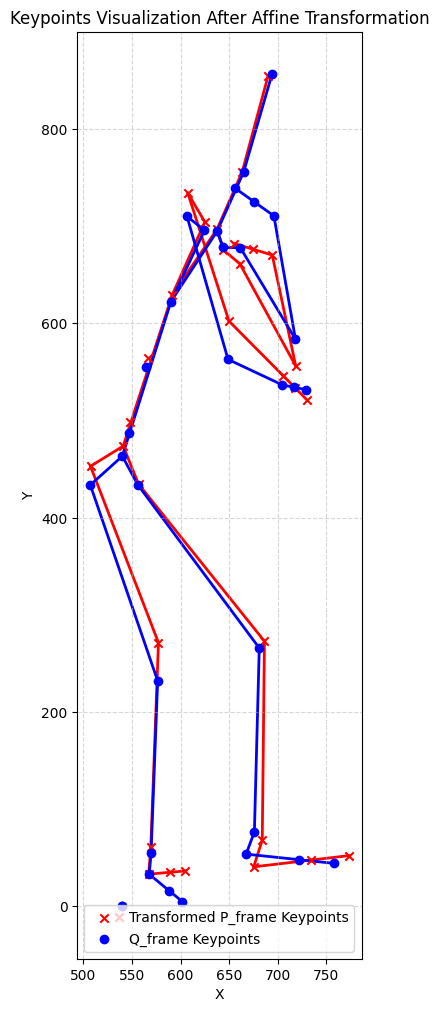

In [21]:
# ==============================
# Visualization
# ==============================

# Plot transformed keypoints and Q_frame keypoints
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot transformed keypoints (from P_frame) in red
plot_skeleton_custom(
    kps_2d=transformed_joints_P,
    ax=ax,
    color='red',
    marker='x',
    show=False,
    invert_y=False
)

# Plot Q_frame keypoints in blue
plot_skeleton_custom(
    kps_2d=Vec_Q_dict,
    ax=ax,
    color='blue',
    marker='o',
    show=False,
    invert_y=False
)

# Add legend
plt.scatter([], [], color='red', label='Transformed P_frame Keypoints', marker='x')
plt.scatter([], [], color='blue', label='Q_frame Keypoints', marker='o')
plt.legend()

plt.title('Keypoints Visualization After Affine Transformation')
plt.show()

## Summary 

To correlate the mathematical formulas with the code:

- **Keypoints:**
  - $ \mathbf{P} $: `pts_P` (NumPy array of points from frame P)
  - $ \mathbf{Q} $: `pts_Q` (NumPy array of points from frame Q)

- **Affine Transformation:**
  - $ \mathbf{M} $: `affine_matrix` (estimated affine matrix)

- **Decomposed Components:**
  - $ \mathbf{R} $: `R` (rotation matrix)
  - $ \mathbf{t} $: `t` (translation vector)
  - $ \mathbf{S} $: `scales` (scaling factors)

- **Residuals and MSE:**
  - $ \text{Residual}_i $: `residuals`
  - $ \text{MSE} $: `mse`
